To have beforehand: 
- Have ft of all elements in dictionary
- Have Python dicitonary mapping indeces of sounds to their convolution

We then use the convolution theorem to compute the convolution of the target and all other sounds in the dictionary. This takes $O(DN \log{N})$ time, where $D$ is the number of sounds in the dictionary and $N$ is the length of the sounds. 

We store the output in a $(N + l_{max} - 1, D)$ matrix, where $l_{max}$ is the length of the longest sound in the dictionary.

We then follow this procedure for $k$ iterations:
    1. Sort all the entries in the matrix
    2. While the matrix is not empty:
        2. Add the max entry to the results array
        3. Remove the simultaneous entries from the matrix 
        4. Add convolution_dict[(i, j)] to matrix_to_subtract
        5. Add sound and time to perm_mask
    3. Subtract matrix_to_subtract from the matrix
    4. Add perm_mask to matrix
    
The sorting is the most expensive part of this algorithm, and takes


We then follow this procedure for $k$ iterations:
    1. Add the max entry to the results array
    2. Subtract dict projections from the matrix
    3. Add sound and time to perm_mask
    4. multiply the matrix by perm_mask

In [1]:
import numpy as np
from scipy.fftpack import fft, ifft
from scipy.io import wavfile
import sounddevice as sd
from multiprocess import Pool, cpu_count
import os

np.random.seed(0)

In [48]:
def load_wav(path, index=[0, -1], verbose=False):
    rate, data = wavfile.read(path)
    data = data[index[0] : index[1]]
    if verbose:
        print("rate: {}, data shape: {}".format(rate, data.shape))
    norm = np.linalg.norm(data)
    data = data.astype(np.float32) / norm
    return data, norm


def load_wavs_to_list(folder_path):
    list_of_sounds = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".wav"):
                wav = os.path.join(root, file)
                sound, _ = load_wav(wav)
                list_of_sounds.append(sound)
    return list_of_sounds


def compute_coefficients(target, list_of_sounds):
    target_length = len(target)
    sounds_count = len(list_of_sounds)
    sound_lengths = [len(sound) for sound in list_of_sounds]
    longest_sound_length = max(sound_lengths)
    conv_matrix_width = longest_sound_length + target_length - 1
    conv_tesor_width = 2 * longest_sound_length - 1
    return (
        target_length,
        sounds_count,
        sound_lengths,
        longest_sound_length,
        conv_matrix_width,
        conv_tesor_width,
    )


def compute_fts(list_of_sounds, width):
    sound_fts = {}
    sound_fts_reverse = {}
    for i, sound in enumerate(list_of_sounds):
        sound_fts[i] = fft(sound, width)
        sound_fts_reverse[i] = fft(sound[::-1], width)
    return sound_fts, sound_fts_reverse


def fft_convolution_for_tensor(args):
    i, j, i_ft, j_ft = args
    return i, j, np.real(ifft(i_ft * j_ft))


def generate_convolution_tensor(
    list_of_sounds,
    conv_tesor_width,
    sound_fts,
    sound_fts_reverse,
    sounds_count,
    verbose=False,
):
    cpus = min(7, cpu_count())
    if verbose:
        print(f"Using {cpus} CPUs")
    convolutions_tensor = np.zeros((sounds_count, sounds_count, conv_tesor_width))
    with Pool(cpus) as pool:
        for i, j, conv in pool.map(
            fft_convolution_for_tensor,
            [
                (i, j, sound_fts[i], sound_fts_reverse[j])
                for i in range(sounds_count)
                for j in range(sounds_count)
            ],
        ):
            convolutions_tensor[i, j, :] = conv
    return convolutions_tensor


def fft_convolution(args):
    i, target_ft, sound_fts_reverse = args
    return np.real(ifft(target_ft * sound_fts_reverse[i]))


def generate_convolution_matrix(
    target_ft,
    sound_fts_reverse,
    verbose=False,
):
    if target_ft.shape[0] != sound_fts_reverse[0].shape[0]:
        raise ValueError(
            "The first dimension of target_ft and sound_fts_reverse[0] must be the same."
        )

    cpus = min(7, cpu_count())
    if verbose:
        print(f"Using {cpus} CPUs")

    args = [(i, target_ft, sound_fts_reverse) for i in range(len(sound_fts_reverse))]
    with Pool(processes=cpus) as pool:
        convolution_matrix = np.array(pool.map(fft_convolution, args))
    return convolution_matrix


def subtract_projections_onto_result(
    i, j, convolution_matrix, convolutions_tensor, lengths, max_val
):
    sound_conv_matrix = convolutions_tensor[i]
    starting_point = max(j - lengths[i] + 1, 0)
    end_point = min(
        sound_conv_matrix.shape[1] + starting_point, convolution_matrix.shape[1]
    )
    convolution_matrix[:, starting_point:end_point] -= (
        sound_conv_matrix[:, : end_point - starting_point] * max_val
    )
    return convolution_matrix


def get_largest_value_index(matrix):
    i, j = np.unravel_index(np.argmax(matrix, axis=None), matrix.shape)
    return i, j, matrix[i, j]

In [75]:
def run_algo(target, list_of_sounds, iterations, tensor_path=None):
    target_norm = np.linalg.norm(target)
    target = target.astype(np.float64) / target_norm
    for i in range(len(list_of_sounds)):
        list_of_sounds[i] = list_of_sounds[i].astype(np.float64) / np.linalg.norm(
            list_of_sounds[i]
        )
    list_of_sounds = sorted(list_of_sounds, key=lambda x: len(x))
    (
        target_length,
        sounds_count,
        sound_lengths,
        longest_sound_length,
        conv_matrix_width,
        conv_tensor_width,
    ) = compute_coefficients(target, list_of_sounds)
    if tensor_path == None:
        sound_fts_for_tensor, sound_fts_reverse_for_tensor = compute_fts(
            list_of_sounds, conv_tensor_width
        )
        convolutions_tensor = generate_convolution_tensor(
            list_of_sounds,
            conv_tensor_width,
            sound_fts_for_tensor,
            sound_fts_reverse_for_tensor,
            sounds_count,
        )
    else:
        convolutions_tensor = np.load(tensor_path)

    target_ft = fft(target, conv_matrix_width)
    sound_fts, sound_fts_reverse = compute_fts(list_of_sounds, conv_matrix_width)

    # print("target ", target)
    # print("sounds ", list_of_sounds)
    # print("convolutions tensor \n", convolutions_tensor)

    convolution_matrix = generate_convolution_matrix(target_ft, sound_fts_reverse)
    # print("Convolution matrix generated")
    # print(convolution_matrix)
    result = np.zeros(target_length)
    perm_mask = np.zeros((sounds_count, conv_matrix_width), dtype=bool)

    for _ in range(iterations):
        # get best match and find the corresponding sound
        i, j, max_val = get_largest_value_index(convolution_matrix * ~perm_mask)
        # print("i, j, max_val", i, j, max_val)
        l = sound_lengths[i]
        start_time, end_time = max(j - l + 1, 0), min(j + 1, target_length)
        clip_start = max(-(j - l + 1), 0)
        clip_end = min(clip_start + end_time - start_time, l)
        matched_sound = list_of_sounds[i][clip_start:clip_end]
        # print("matched sound ", matched_sound)

        # update result and target
        result[start_time:end_time] += matched_sound * max_val
        target[start_time:end_time] -= matched_sound * max_val

        # compute new convolution matrix
        # print("result ", result)
        # print("new target ", target)
        convolution_matrix1 = subtract_projections_onto_result(
            i, j, convolution_matrix, convolutions_tensor, sound_lengths, max_val
        )
        # print("convolution matrix after subtraction \n", convolution_matrix1)

        # compute convolution matrix v2
        target_ft = fft(target, conv_matrix_width)
        convolution_matrix = generate_convolution_matrix(target_ft, sound_fts_reverse)
        # print("convolution matrix computed from target \n", convolution_matrix)

        match = np.isclose(convolution_matrix, convolution_matrix1)
        # print("matrix match \n", match)
        if not match.all():
            print("matrix match failed")
            break

        # update perm mask
        end_perm_mask = min(
            start_time + 2 * (end_time - start_time) - 1, conv_matrix_width
        )
        perm_mask[i, start_time:end_perm_mask] = True
        # print("perm mask \n", perm_mask * 1)

    return result * target_norm

In [101]:
import time


def run_algo(target, list_of_sounds, iterations, tensor_path=None):
    time_data = {}
    square_distance = []

    # 1
    s = time.time()
    target_norm = np.linalg.norm(target)
    target = target.astype(np.float64) / target_norm
    original_target = target.copy()
    for i in range(len(list_of_sounds)):
        list_of_sounds[i] = list_of_sounds[i].astype(np.float64) / np.linalg.norm(
            list_of_sounds[i]
        )
    list_of_sounds = sorted(list_of_sounds, key=lambda x: len(x))
    (
        target_length,
        sounds_count,
        sound_lengths,
        longest_sound_length,
        conv_matrix_width,
        conv_tensor_width,
    ) = compute_coefficients(target, list_of_sounds)
    time_data[1] = time.time() - s

    # 2
    s = time.time()
    if tensor_path == None:
        sound_fts_for_tensor, sound_fts_reverse_for_tensor = compute_fts(
            list_of_sounds, conv_tensor_width
        )
        convolutions_tensor = generate_convolution_tensor(
            list_of_sounds,
            conv_tensor_width,
            sound_fts_for_tensor,
            sound_fts_reverse_for_tensor,
            sounds_count,
        )
    else:
        convolutions_tensor = np.load(tensor_path)
    time_data[2] = time.time() - s

    # 3
    s = time.time()
    target_ft = fft(target, conv_matrix_width)
    sound_fts, sound_fts_reverse = compute_fts(list_of_sounds, conv_matrix_width)
    time_data[3] = time.time() - s

    # 4
    s = time.time()
    convolution_matrix = generate_convolution_matrix(target_ft, sound_fts_reverse)
    result = np.zeros(target_length)
    perm_mask = np.zeros((sounds_count, conv_matrix_width), dtype=bool)
    time_data[4] = time.time() - s

    for _ in range(iterations):
        # 5
        s = time.time()
        i, j, max_val = get_largest_value_index(convolution_matrix * ~perm_mask)
        l = sound_lengths[i]
        start_time, end_time = max(j - l + 1, 0), min(j + 1, target_length)
        clip_start = max(-(j - l + 1), 0)
        clip_end = min(clip_start + end_time - start_time, l)
        matched_sound = list_of_sounds[i][clip_start:clip_end]
        time_data[5] = time_data.get(5, 0) + (time.time() - s)

        # update result and target
        result[start_time:end_time] += matched_sound * max_val
        target[start_time:end_time] -= matched_sound * max_val

        # 6
        s = time.time()
        convolution_matrix = subtract_projections_onto_result(
            i, j, convolution_matrix, convolutions_tensor, sound_lengths, max_val
        )
        time_data[6] = time_data.get(6, 0) + (time.time() - s)

        # 7
        # s = time.time()
        # target_ft = fft(target, conv_matrix_width)
        # convolution_matrix1 = generate_convolution_matrix(target_ft, sound_fts_reverse)
        # time_data[7] = time_data.get(7, 0) + (time.time() - s)

        # 8
        # s = time.time()
        # match = np.isclose(convolution_matrix, convolution_matrix1)
        # if not match.all():
        # print("matrix match failed")
        # print(_)
        # print where values are not close and the difference
        # print(convolution_matrix[~match] - convolution_matrix1[~match])
        # break
        #    pass
        # time_data[8] = time_data.get(8, 0) + (time.time() - s)

        # update perm mask
        end_perm_mask = min(
            start_time + 2 * (end_time - start_time) - 1, conv_matrix_width
        )
        perm_mask[i, start_time:end_perm_mask] = True

        square_distance.append(np.linalg.norm(original_target - result))

    for key, value in time_data.items():
        print(
            f"Component {key}: Average time over iterations = {value / iterations:.5f} seconds"
        )

    return result * target_norm, square_distance

In [106]:
np.set_printoptions(formatter={"float_kind": lambda x: "%.2f" % x})
# target 1000 long, 3 sounds, 1000 long
target = np.random.rand(10000)
list_of_sounds = [np.random.rand(100) for _ in range(30)]
iterations = 1000
result, square_distance = run_algo(target, list_of_sounds, iterations)

Component 1: Average time over iterations = 0.00000 seconds
Component 2: Average time over iterations = 0.00013 seconds
Component 3: Average time over iterations = 0.00003 seconds
Component 4: Average time over iterations = 0.00024 seconds
Component 5: Average time over iterations = 0.00032 seconds
Component 6: Average time over iterations = 0.00002 seconds


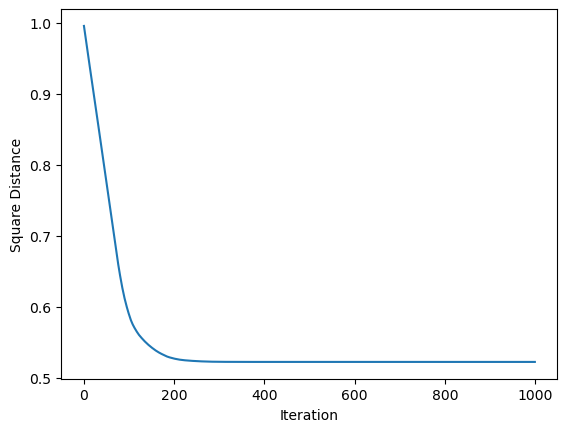

In [107]:
# plot square distance
import matplotlib.pyplot as plt

plt.plot(square_distance)
plt.xlabel("Iteration")
plt.ylabel("Square Distance")
plt.show()

In [70]:
# target, target_norm = load_wav(target_path, [0, 160000], verbose=True)
# list_of_sounds = load_wavs_to_list(sounds_path)
# iterations = 10
# run_algo(target, list_of_sounds, iterations, tensor_path="convolutions_tensor.npy")

In [44]:
# toy example for debugging
target = np.array([1, 1, 2])
sound_dict = [np.array([1]), np.array([2, 1])]
target = target.astype(np.float64) / np.linalg.norm(target)
for i in range(len(sound_dict)):
    sound_dict[i] = sound_dict[i].astype(np.float64) / np.linalg.norm(sound_dict[i])
print("target:", target)
print("sound_dict:", sound_dict)
lengths = [len(sound) for sound in sound_dict]
l_max = max(lengths)
D = len(sound_dict)
N = len(target)
conv_matrix_width = l_max + N - 1

conv_tensor_width = 2 * l_max - 1

target_ft = fft(target, conv_matrix_width)
sound_fts = {}
sound_fts_reverse = {}
for i, sound in enumerate(sound_dict):
    sound_fts[i] = fft(sound, conv_tensor_width)
    sound_fts_reverse[i] = fft(sound[::-1], conv_tensor_width)

convolutions_tensor = generate_convolution_dict_parallelized()
print(convolutions_tensor)

sound_fts = {}
sound_fts_reverse = {}
for i, sound in enumerate(sound_dict):
    sound_fts[i] = fft(sound, conv_matrix_width)
    sound_fts_reverse[i] = fft(sound[::-1], conv_matrix_width)

algo(target, 2)

target: [0.40824829 0.40824829 0.81649658]
sound_dict: [array([1.]), array([0.89442719, 0.4472136 ])]


NameError: name 'generate_convolution_dict_parallelized' is not defined

In [30]:
result = algo(100)

Convolution matrix generated


In [31]:
# see number of non-zero elements
print(np.count_nonzero(result))
# play result
wavfile.write("result1000.wav", 44100, result.astype(np.int16))

51528


In [49]:
# add 1 significant digit numpy
np.printoptions(formatter={"float": lambda x: "{0:0.1f}".format(x)})

In [24]:
def convolve(x, y, n):
    return np.real(ifft(fft(x[::-1], n) * fft(y, n)))


x, y = [1, 2, 3], [3, 1]
convolve(y, x, len(x) + len(y) - 1)

array([1., 5., 9., 9.])

In [51]:
def convolve(x, y, n):
    return np.real(ifft(fft(x, n) * fft(y, n)))


x = fft(np.array([1, 2]), 5)
y = fft(np.array([2, 2]), 5)
z = fft(np.array([1, 2, 3]), 5)


dictt = {0: x, 1: y, 2: z}

generate_convolution_matrix_looped(z, dictt, D=3, conv_matrix_width=5)

TypeError: generate_convolution_matrix_looped() got an unexpected keyword argument 'D'

In [87]:
if __name__ == "__main__":
    convolution_matrix = generate_convolution_matrix()